In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data

Dataset: https://github.com/garythung/trashnet
The dataset spans six classes: glass, paper, cardboard, plastic, metal, and trash. Currently, the dataset consists of 2527 images:

501 glass
594 paper
403 cardboard
482 plastic
410 metal
137 trash

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\nanin\\Desktop\\ReBin\\dataset-resized'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

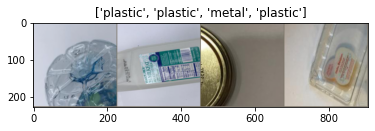

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
Generic function to display predictions for a few images

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [7]:
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\nanin/.cache\torch\checkpoints\googlenet-1378be20.pth


Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.3204 Acc: 0.5002
val Loss: 0.7677 Acc: 0.7117

Epoch 1/9
----------
train Loss: 1.0458 Acc: 0.6312
val Loss: 0.6022 Acc: 0.7742

Epoch 2/9
----------
train Loss: 0.9629 Acc: 0.6460
val Loss: 0.4966 Acc: 0.8125

Epoch 3/9
----------
train Loss: 0.8918 Acc: 0.6854
val Loss: 0.4589 Acc: 0.8508

Epoch 4/9
----------
train Loss: 0.8452 Acc: 0.7016
val Loss: 0.4667 Acc: 0.8327

Epoch 5/9
----------
train Loss: 0.7680 Acc: 0.7312
val Loss: 0.4229 Acc: 0.8548

Epoch 6/9
----------
train Loss: 0.7376 Acc: 0.7356
val Loss: 0.3921 Acc: 0.8488

Epoch 7/9
----------
train Loss: 0.6553 Acc: 0.7779
val Loss: 0.3446 Acc: 0.8891

Epoch 8/9
----------
train Loss: 0.5715 Acc: 0.8124
val Loss: 0.3486 Acc: 0.8891

Epoch 9/9
----------
train Loss: 0.5756 Acc: 0.8070
val Loss: 0.3153 Acc: 0.8931

Training complete in 107m 28s
Best val Acc: 0.893145


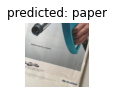

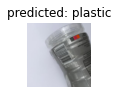

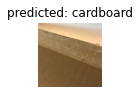

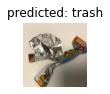

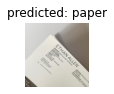

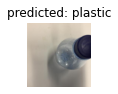

In [9]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3740 Acc: 0.4889
val Loss: 0.8202 Acc: 0.6956

Epoch 1/24
----------
train Loss: 1.1950 Acc: 0.5647
val Loss: 0.7400 Acc: 0.7157

Epoch 2/24
----------
train Loss: 1.1905 Acc: 0.5849
val Loss: 0.7384 Acc: 0.7560

Epoch 3/24
----------
train Loss: 1.1523 Acc: 0.5889
val Loss: 0.6900 Acc: 0.7440

Epoch 4/24
----------
train Loss: 1.0963 Acc: 0.6194
val Loss: 0.6346 Acc: 0.7702

Epoch 5/24
----------
train Loss: 1.0704 Acc: 0.6174
val Loss: 0.8728 Acc: 0.7198

Epoch 6/24
----------
train Loss: 1.1041 Acc: 0.6209
val Loss: 0.5807 Acc: 0.7984

Epoch 7/24
----------
train Loss: 0.9577 Acc: 0.6435
val Loss: 0.5328 Acc: 0.8044

Epoch 8/24
----------
train Loss: 0.9119 Acc: 0.6750
val Loss: 0.5007 Acc: 0.8306

Epoch 9/24
----------
train Loss: 0.8950 Acc: 0.6741
val Loss: 0.5132 Acc: 0.8065

Epoch 10/24
----------
train Loss: 0.8697 Acc: 0.6873
val Loss: 0.5085 Acc: 0.8306

Epoch 11/24
----------
train Loss: 0.8978 Acc: 0.6736
val Loss: 0.4992 Acc: 0.8145

Ep

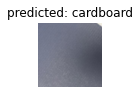

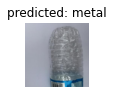

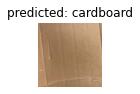

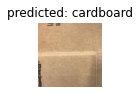

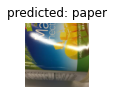

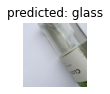

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model_conv, train, val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


Save and Load 

In [ ]:
PATH = "2ND_MODEL.pt"

torch.save(net.state_dict(), PATH)

#load
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
# Specify a path
PATH = "entire_2ND_MODEL.pt"

# Save
torch.save(net, PATH)

# Load
model = torch.load(PATH)
model.eval()